In [1]:
import numpy as np
import tensorflow as tf
import shap
import matplotlib.pyplot as plt
from interaction_effects import run_image, utils, marginal
from regularized_explanations import eager_ops, plot

In [2]:
from absl import app
from absl import flags

FLAGS = flags.FLAGS

flags.DEFINE_string('f', '', 'Default')
try:
    app.run(lambda x: None)
except:
    pass

In [3]:
tf.enable_eager_execution()

In [4]:
utils.set_up_environment()

In [5]:
FLAGS.dataset = 'color_mnist'

In [6]:
x_train, y_train, x_test, y_test = run_image.get_data()

In [7]:
model = tf.keras.models.load_model('../models/{}_model.h5'.format(FLAGS.dataset))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


W1105 10:01:47.597312 140258085336896 deprecation.py:323] From /home/psturm/anaconda3/lib/python3.6/site-packages/tensorflow_core/python/ops/math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [16]:
eg_test_batch = eager_ops.expected_gradients_multi_output(tf.constant(x_test[:5]), x_train, model, 10, k=100)

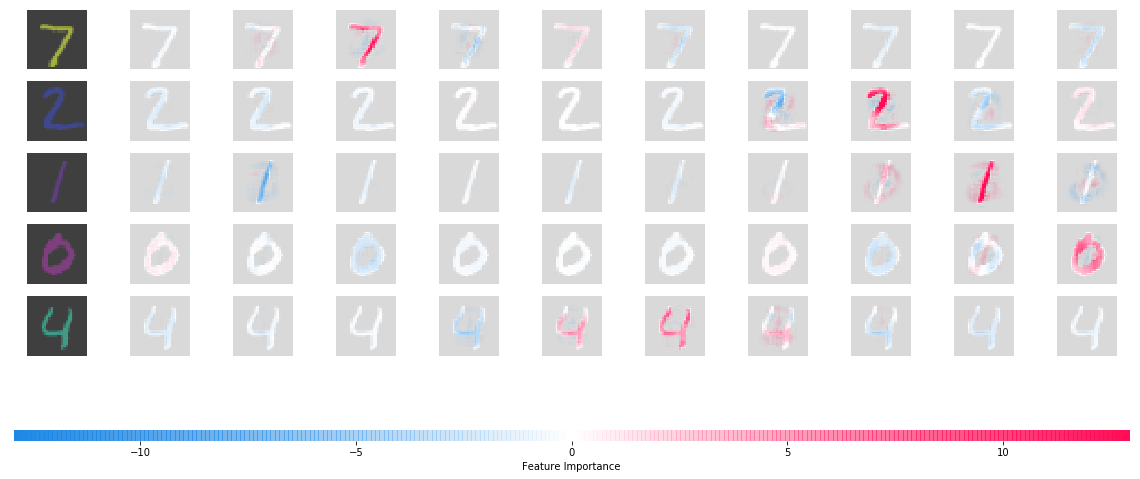

In [22]:
plot.image_plot(utils.batch_standardize(eg_test_batch.numpy()), x_test[:5] * 0.5 + 0.5, as_array=True)

In [24]:
primal_explainer = marginal.MarginalExplainer(model, x_train, 
                                         nsamples=200, representation='mobius')
primal_effects = primal_explainer.explain(x_test[:5], verbose=True)


100%|██████████| 5/5 [04:36<00:00, 55.28s/it]

In [36]:
class_selected_shap_values = eg_test_batch.numpy()[np.arange(5), np.argmax(model(x_test[:5]), axis=-1), :, :, :]

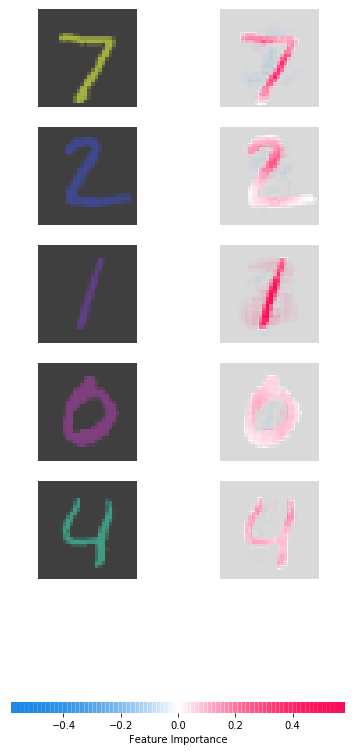

In [53]:
plot.image_plot(class_selected_shap_values, x_test[:5] * 0.5 + 0.5, as_array=False)

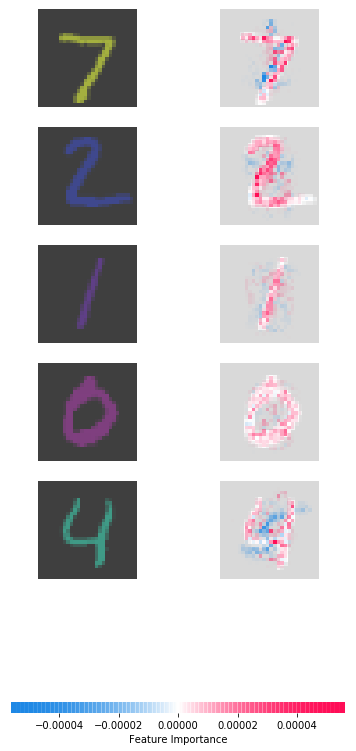

In [52]:
plot.image_plot(primal_effects, x_test[:5] * 0.5 + 0.5, as_array=False)

In [38]:
interaction_effects = class_selected_shap_values - primal_effects

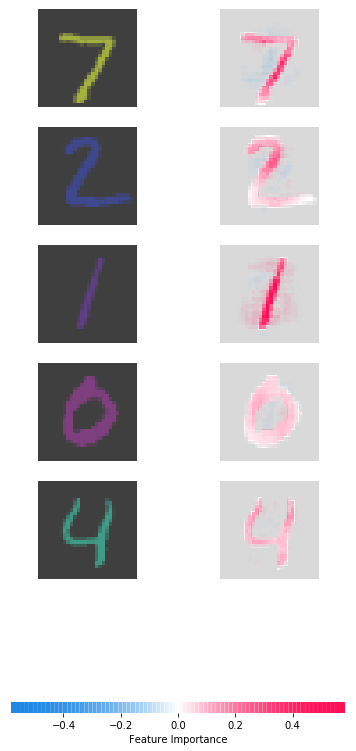

In [51]:
plot.image_plot(class_selected_shap_values-primal_effects, x_test[:5] * 0.5 + 0.5, as_array=False)

Same as above, except now using black as a reference

In [56]:
eg_test_batch = eager_ops.expected_gradients_multi_output(tf.constant(x_test[:5]), np.zeros((100, 28, 28, 3)), model, 10, k=100)

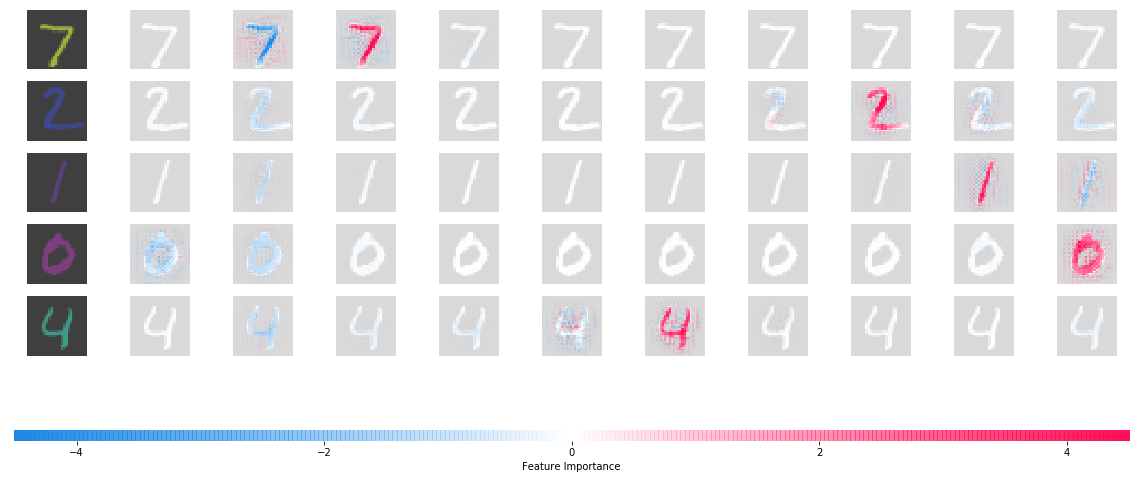

In [57]:
plot.image_plot(utils.batch_standardize(eg_test_batch.numpy()), x_test[:5] * 0.5 + 0.5, as_array=True)

In [59]:
primal_explainer = marginal.MarginalExplainer(model, np.zeros((1, 28, 28, 3)).astype(np.float32), 
                                         nsamples=200, representation='mobius')
primal_effects = primal_explainer.explain(x_test[:5], verbose=True)



  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:13<00:52, 13.06s/it]

 40%|████      | 2/5 [00:26<00:39, 13.04s/it]

 60%|██████    | 3/5 [00:38<00:26, 13.01s/it]

 80%|████████  | 4/5 [00:51<00:12, 13.00s/it]

100%|██████████| 5/5 [01:04<00:00, 13.00s/it]

In [60]:
class_selected_shap_values = eg_test_batch.numpy()[np.arange(5), np.argmax(model(x_test[:5]), axis=-1), :, :, :]

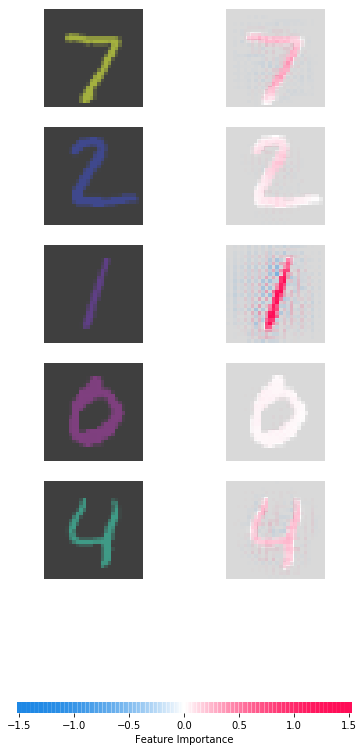

In [61]:
plot.image_plot(class_selected_shap_values, x_test[:5] * 0.5 + 0.5, as_array=False)

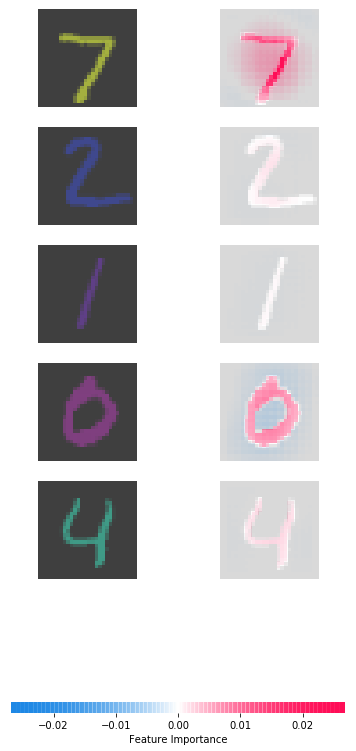

In [62]:
plot.image_plot(primal_effects, x_test[:5] * 0.5 + 0.5, as_array=False)

In [63]:
interaction_effects = class_selected_shap_values - primal_effects

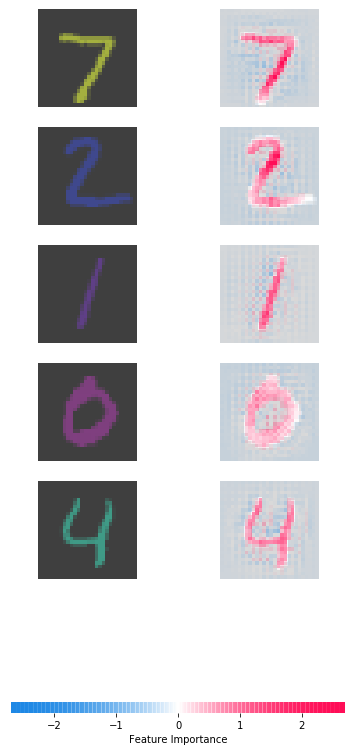

In [67]:
plot.image_plot(utils.batch_standardize(class_selected_shap_values-primal_effects, multi_class=False), x_test[:5] * 0.5 + 0.5, as_array=False)

In [69]:
model_func = lambda x: model(np.reshape(x, (x.shape[0], 28, 28, 3)).astype(np.float32)).numpy()
sample_explainer = shap.SamplingExplainer(model_func,
                                              np.reshape(x_train[:200], 
                                                         (200, -1)))
shap_values = sample_explainer.shap_values(np.reshape(x_test[:5], 
                                                      (5, -1)))
shap_values = np.stack(shap_values, axis=0)
shap_values = shap_values[np.argmax(model(x_test[:5]), axis=-1), np.arange(shap_values.shape[1]), :]

In [71]:
shap_values = np.reshape(shap_values, (5, 28, 28, 3))

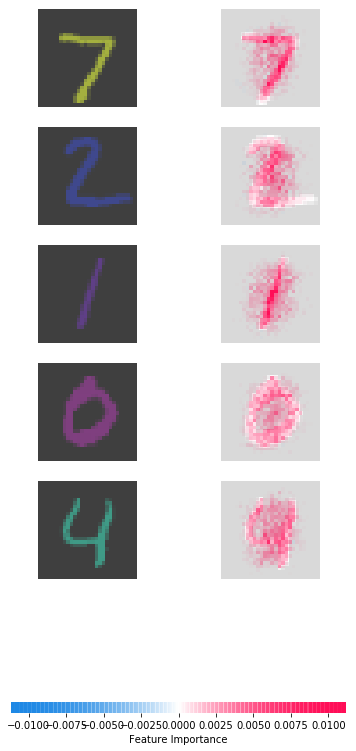

In [72]:
plot.image_plot(shap_values, x_test[:5] * 0.5 + 0.5, as_array=False)

In [73]:
primal_explainer = marginal.MarginalExplainer(model, x_train, 
                                         nsamples=200, representation='mobius')
primal_effects = primal_explainer.explain(x_test[:5], verbose=True)



  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:55<03:40, 55.20s/it]

 40%|████      | 2/5 [01:50<02:45, 55.25s/it]

 60%|██████    | 3/5 [02:46<01:50, 55.33s/it]

 80%|████████  | 4/5 [03:41<00:55, 55.32s/it]

100%|██████████| 5/5 [04:36<00:00, 55.33s/it]

In [74]:
interaction_effects = shap_values - primal_effects

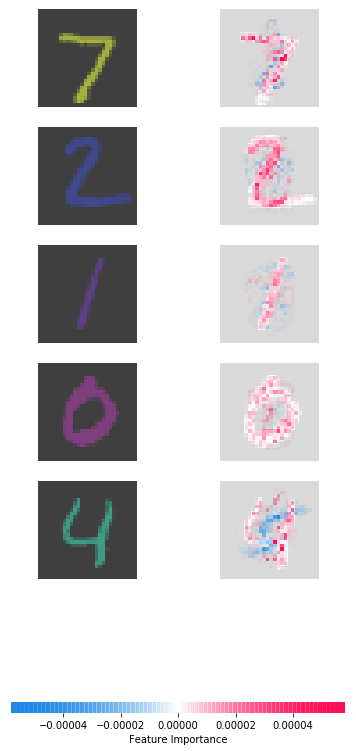

In [75]:
plot.image_plot(primal_effects, x_test[:5] * 0.5 + 0.5, as_array=False)

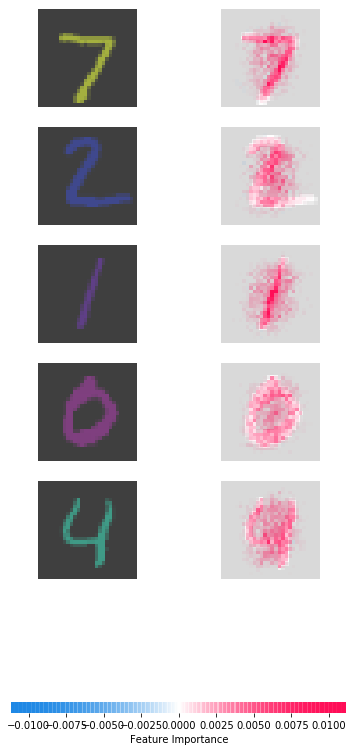

In [76]:
plot.image_plot(interaction_effects, x_test[:5] * 0.5 + 0.5, as_array=False)

In [94]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [95]:
from interaction_effects.marginal_grad import MarginalGradExplainer

In [96]:
primal_explainer = MarginalGradExplainer(model, np.zeros((200, 28, 28, 3)).astype(np.float32), 
                                         nsamples=200, representation='mobius')
primal_effects = primal_explainer.explain(x_test[:5], verbose=True)

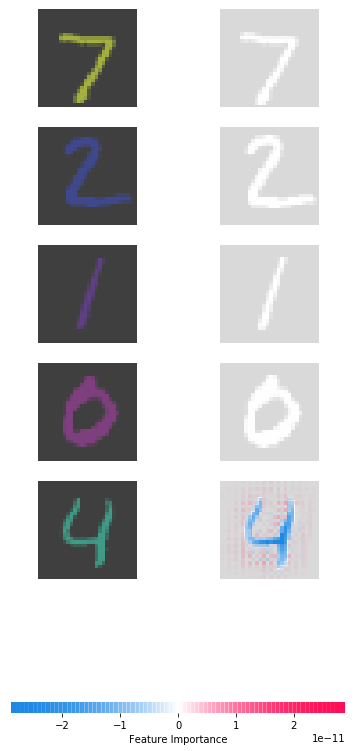

In [98]:
plot.image_plot(primal_effects, x_test[:5] * 0.5 + 0.5, as_array=False)